# Weedle's Cave
Weedle's Cave is a kaggle competition that can be found here: https://www.kaggle.com/terminus7/pokemon-challenge. <br/><br/>
The goal is to predict the outcome of a pokemon battle given the 2 pokemon. Our training set has the history of previous pokemon battles and who was the victor. In addition, there's a csv provided with the stats of every pokemon.<br/><br/>
My childhood domain knowledge may come in handy for this dataset so let's predict them all! (Cringy I know)

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import combinations

%matplotlib inline

### Import

In [78]:
combat_df = pd.read_csv('./dataset/combats.csv')
pokemon_df = pd.read_csv('./dataset/pokemon.csv')
test_df = pd.read_csv('./dataset/test.csv')

### EDA

In [79]:
# What the dataframes look like
print(combat_df.head())
print('')
print(pokemon_df.head())

   First_pokemon  Second_pokemon  Winner
0            266             298     298
1            702             701     701
2            191             668     668
3            237             683     683
4            151             231     151

   #           Name Type 1  Type 2  HP  Attack  Defense  Sp. Atk  Sp. Def  \
0  1      Bulbasaur  Grass  Poison  45      49       49       65       65   
1  2        Ivysaur  Grass  Poison  60      62       63       80       80   
2  3       Venusaur  Grass  Poison  80      82       83      100      100   
3  4  Mega Venusaur  Grass  Poison  80     100      123      122      120   
4  5     Charmander   Fire     NaN  39      52       43       60       50   

   Speed  Generation  Legendary  
0     45           1      False  
1     60           1      False  
2     80           1      False  
3     80           1      False  
4     65           1      False  


We'll rename the column names in the pokemon_df dataframe so there aren't any spaces or periods.

In [80]:
pokemon_df.columns = [col.replace(' ', '_').replace('.', '').lower() \
                      for col in pokemon_df.columns]
pokemon_df.columns

Index(['#', 'name', 'type_1', 'type_2', 'hp', 'attack', 'defense', 'sp_atk',
       'sp_def', 'speed', 'generation', 'legendary'],
      dtype='object')

In [81]:
print(combat_df.isnull().sum())
print('')
print(pokemon_df.isnull().sum())

First_pokemon     0
Second_pokemon    0
Winner            0
dtype: int64

#               0
name            1
type_1          0
type_2        386
hp              0
attack          0
defense         0
sp_atk          0
sp_def          0
speed           0
generation      0
legendary       0
dtype: int64


Looks like there's several Nans in the Type 2 column. I'll assume this means the pokemon with the Nans are of a single type. In this case we'll impute the value with the same type as the Type 1 column.

In [82]:
pokemon_df['type_2'] = pokemon_df['type_2'].fillna(pokemon_df['type_1'])

pokemon_df.isnull().sum()

#             0
name          1
type_1        0
type_2        0
hp            0
attack        0
defense       0
sp_atk        0
sp_def        0
speed         0
generation    0
legendary     0
dtype: int64

In [83]:
# See entry with Nan as name
pokemon_df[pokemon_df.isnull().any(axis=1)]

,#,name,type_1,type_2,hp,attack,defense,sp_atk,sp_def,speed,generation,legendary
62,63,NaN,Fighting,Fighting,65,105,60,60,70,95,1,False


In [84]:
pokemon_df.iloc[60:65, :]

,#,name,type_1,type_2,hp,attack,defense,sp_atk,sp_def,speed,generation,legendary
60,61,Golduck,Water,Water,80,82,78,95,80,85,1,False
61,62,Mankey,Fighting,Fighting,40,80,35,35,45,70,1,False
62,63,NaN,Fighting,Fighting,65,105,60,60,70,95,1,False
63,64,Growlithe,Fire,Fire,55,70,45,70,50,60,1,False
64,65,Arcanine,Fire,Fire,90,110,80,100,80,95,1,False


Mankey evolves to........ Primape!

In [85]:
pokemon_df.iloc[62, 1] = 'Primeape'

# OCD check
pokemon_df.iloc[61:63, 1].to_frame()

,name
61,Mankey
62,Primeape


In [130]:
# Pokemon summary stats
sum_stats = pokemon_df.describe()[['hp', 'attack', 'defense', 'sp_atk', \
                      'sp_def', 'speed']]
sum_stats

,hp,attack,defense,sp_atk,sp_def,speed
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500
std,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474
min,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000
50%,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000
75%,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000
max,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000


All the stats look to be on a similar scale. I.E. the mean, min, max, and standard deviations are very similar to each other in value.

In [97]:
# See unique types
all_types = set(pokemon_df['type_1'])

for tpe in set(pokemon_df['type_2']):
    if tpe not in all_types:
        all_types.append(tpe)

print('Number of unique types: ', len(all_types))
all_types

Number of unique types:  18


{'Bug',
 'Dark',
 'Dragon',
 'Electric',
 'Fairy',
 'Fighting',
 'Fire',
 'Flying',
 'Ghost',
 'Grass',
 'Ground',
 'Ice',
 'Normal',
 'Poison',
 'Psychic',
 'Rock',
 'Steel',
 'Water'}

In [103]:
# Number of type combinations
len(list(combinations(all_types, 2)))

153

There are 18 unique types, but because a pokemon can have a combination of 2 types there are potentially 153 + 18 = 171 unique pokemon types.

Number of unique pokemon typing: 154


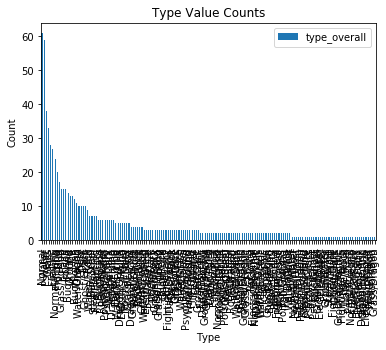

,type_overall
Normal,61
Water,59
Psychic,38
Grass,33
Fire,28
Electric,27
Normal/Flying,24
Fighting,20
Bug,17
Grass/Poison,15


In [121]:
# Create column for overall pokemon type
pokemon_df['type_overall'] = np.where(pokemon_df['type_1'] != pokemon_df['type_2'], \
                    pokemon_df['type_1'] + '/' + pokemon_df['type_2'], pokemon_df['type_1'])

print('Number of unique pokemon typing:', \
      len(pokemon_df['type_overall'].value_counts()))

# Create bar chart of value counts
pokemon_df['type_overall'].value_counts().to_frame().plot(kind='bar')
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Type Value Counts')
plt.show()

# Top 20 pokemon typing
pokemon_df['type_overall'].value_counts().to_frame().head(20)

Common typing seems to be single types.

In [126]:
# Generation value counts
pokemon_df['generation'].value_counts().to_frame()

,generation
1,166
5,165
3,160
4,121
2,106
6,82


Looks to be a downward trend on new pokemon in the later generations. This makes sense as pokemon from older generations are recycled into the new generation in the games.

In [124]:
# Change legendary column to binary
pokemon_df['legendary'].map(lambda x: 1 if x == True else 0)

print('Number of legendaries: ', sum(pokemon_df['legendary']))

Number of legendaries:  65


In [132]:
# Legendary summary stats 
sum_stats_leg = pokemon_df[pokemon_df['legendary']==1].describe()[sum_stats.columns]
sum_stats_leg

,hp,attack,defense,sp_atk,sp_def,speed
count,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000
mean,92.738462,116.676923,99.661538,122.184615,105.938462,100.184615
std,21.722164,30.348037,28.255131,31.104608,28.827004,22.952323
min,50.000000,50.000000,20.000000,50.000000,20.000000,50.000000
25%,80.000000,100.000000,90.000000,100.000000,90.000000,90.000000
50%,91.000000,110.000000,100.000000,120.000000,100.000000,100.000000
75%,105.000000,131.000000,115.000000,150.000000,120.000000,110.000000
max,150.000000,190.000000,200.000000,194.000000,200.000000,180.000000


In [138]:
# Non-legendary summary stats
sum_stats_norm = pokemon_df[pokemon_df['legendary']==0].describe()[sum_stats.columns]
sum_stats_norm

,hp,attack,defense,sp_atk,sp_def,speed
count,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000
mean,67.182313,75.669388,71.559184,68.454422,68.892517,65.455782
std,24.808849,30.490153,30.408194,29.091705,25.669310,27.843038
min,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,50.000000,54.500000,50.000000,45.000000,50.000000,45.000000
50%,65.000000,72.000000,66.000000,65.000000,65.000000,64.000000
75%,79.500000,95.000000,85.000000,85.000000,85.000000,85.000000
max,255.000000,185.000000,230.000000,175.000000,230.000000,160.000000


In [139]:
# Delta between all pokemon summary stats and legendary summary stats
sum_stats_leg - sum_stats_norm

,hp,attack,defense,sp_atk,sp_def,speed
count,-670.000000,-670.000000,-670.000000,-670.000000,-670.000000,-670.000000
mean,25.556149,41.007535,28.102355,53.730194,37.045945,34.728833
std,-3.086685,-0.142115,-2.153064,2.012903,3.157693,-4.890715
min,49.000000,45.000000,15.000000,40.000000,0.000000,45.000000
25%,30.000000,45.500000,40.000000,55.000000,40.000000,45.000000
50%,26.000000,38.000000,34.000000,55.000000,35.000000,36.000000
75%,25.500000,36.000000,30.000000,65.000000,35.000000,25.000000
max,-105.000000,5.000000,-30.000000,19.000000,-30.000000,20.000000


Legendary pokemon have a significant stat bump from the rest of the pokemon- especially in the attack stat.<br/><br/>
Let's now join the 2 dataframes we have.

In [152]:
# First make 3 copies of the pokemon_df dataframe
df_1 = pokemon_df.copy()
df_2 = pokemon_df.copy()
df_w = pokemon_df.copy()

# Rename the columns to be able to index by first, second, and winner
df_1.columns = [col + '_1' for col in pokemon_df.columns]
df_2.columns = [col + '_2' for col in pokemon_df.columns]
df_w.columns = [col + '_w' for col in pokemon_df.columns]

# Merge the 3 dataframes together
join_1 = pd.merge(combat_df, df_1, left_on='First_pokemon', right_on='#_1')
join_2 = pd.merge(join_1, df_2, left_on='Second_pokemon', right_on='#_2')
connected_df = pd.merge(join_2, df_w[['#_w', 'name_w']], left_on='Winner', right_on='#_w')

connected_df.head()

,First_pokemon,Second_pokemon,Winner,#_1,name_1,type_1_1,type_2_1,hp_1,attack_1,defense_1,...,attack_2,defense_2,sp_atk_2,sp_def_2,speed_2,generation_2,legendary_2,type_overall_2,#_w,name_w
0,266,298,298,266,Larvitar,Rock,Ground,50,64,50,...,70,40,60,40,60,3,False,Grass/Dark,298,Nuzleaf
1,73,298,298,73,Machop,Fighting,Fighting,70,80,50,...,70,40,60,40,60,3,False,Grass/Dark,298,Nuzleaf
2,373,298,298,373,Whiscash,Water,Ground,110,78,73,...,70,40,60,40,60,3,False,Grass/Dark,298,Nuzleaf
3,659,298,298,659,Ferroseed,Grass,Steel,44,50,91,...,70,40,60,40,60,3,False,Grass/Dark,298,Nuzleaf
4,517,298,298,517,Tangrowth,Grass,Grass,100,100,125,...,70,40,60,40,60,3,False,Grass/Dark,298,Nuzleaf


Let's now do some EDA on which type of pokemon were likely to win their battle.

In [154]:
# Top 10 pokemon with highest number of wins
connected_df['name_w'].value_counts().to_frame().head(10)

,name_w
Mewtwo,152
Infernape,136
Aerodactyl,136
Jirachi,134
Slaking,133
Deoxys Speed Forme,133
Mega Absol,130
Murkrow,130
Mega Houndoom,128
Mega Aerodactyl,127


In [157]:
# Bottom 10 pokemon with lowest number of wins
connected_df['name_w'].value_counts().to_frame().tail(10)

,name_w
Cascoon,7
Cleffa,7
Wooper,6
Wynaut,6
Igglybuff,5
Munna,5
Slugma,4
Solosis,4
Togepi,3
Silcoon,3


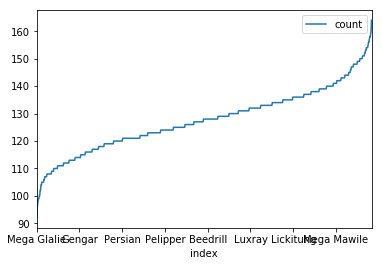

In [214]:
# See if there's any pokemon overly or underly present in the matches
# by looking at the value counts of the first and second columns in the
# matches
present_1 = connected_df['name_1'].value_counts().to_frame().reset_index()
present_2 = connected_df['name_2'].value_counts().to_frame().reset_index()

present_df = pd.merge(present_1, present_2, left_on='index', right_on='index')
present_df['count'] = present_df['name_1'] + present_df['name_2']

present_df.sort_values('count').plot('index', 'count')
# present_df.sort_values('count').plot('index', 'count')
# plt.xlabel('Pokemon')
# plt.ylabel('Count')

There isn't an even distribution, but with the lower end at ~105 and higher end ~155 it doesn't look too unbalanced.<br/><br/> 
Now to see the most likely winning pokemon types.

### Modeling

In [215]:
# Set up feature matrix and target vector

X = connected_df.drop('First_pokemon', 'Second_pokemon', 'Winner', \
                     )
connected_df

,First_pokemon,Second_pokemon,Winner,#_1,name_1,type_1_1,type_2_1,hp_1,attack_1,defense_1,...,attack_2,defense_2,sp_atk_2,sp_def_2,speed_2,generation_2,legendary_2,type_overall_2,#_w,name_w
0,266,298,298,266,Larvitar,Rock,Ground,50,64,50,...,70,40,60,40,60,3,False,Grass/Dark,298,Nuzleaf
1,73,298,298,73,Machop,Fighting,Fighting,70,80,50,...,70,40,60,40,60,3,False,Grass/Dark,298,Nuzleaf
2,373,298,298,373,Whiscash,Water,Ground,110,78,73,...,70,40,60,40,60,3,False,Grass/Dark,298,Nuzleaf
3,659,298,298,659,Ferroseed,Grass,Steel,44,50,91,...,70,40,60,40,60,3,False,Grass/Dark,298,Nuzleaf
4,517,298,298,517,Tangrowth,Grass,Grass,100,100,125,...,70,40,60,40,60,3,False,Grass/Dark,298,Nuzleaf
5,347,298,298,347,Swalot,Poison,Poison,100,73,83,...,70,40,60,40,60,3,False,Grass/Dark,298,Nuzleaf
6,347,298,298,347,Swalot,Poison,Poison,100,73,83,...,70,40,60,40,60,3,False,Grass/Dark,298,Nuzleaf
7,668,298,298,668,Beheeyem,Psychic,Psychic,75,75,75,...,70,40,60,40,60,3,False,Grass/Dark,298,Nuzleaf
8,788,298,298,788,Gourgeist Super Size,Ghost,Grass,85,100,122,...,70,40,60,40,60,3,False,Grass/Dark,298,Nuzleaf
9,317,298,298,317,Shedinja,Bug,Ghost,1,90,45,...,70,40,60,40,60,3,False,Grass/Dark,298,Nuzleaf
